## Install Libraries

In [1]:
# !pip install opencv-python

In [4]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm 

## Define Constants

In [7]:
HOME = os.getcwd()
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
print(HOME)

/Users/ivynyak/Documents/GitHub/scdf-dell-2024


## Resize Images

In [4]:
def resize_all(path, length, X, Y):
    for i in tqdm(range(1, length + 1), desc='Processing images'):
        IMG_PATH = f"{HOME}{path}images/img({i}).jpg"
        MASK_PATH = f"{HOME}{path}masks/img({i}).png"

        img = imread(IMG_PATH)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[i-1] = img

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
        mask_ = imread(MASK_PATH)
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)

        Y[i-1] = mask

    return X, Y

In [5]:
TRAIN_PATH = '/dataset/train/'
TEST_PATH = '/dataset/test/'

TRAIN_LENGTH = len(os.listdir(HOME + '/dataset/train/images'))
TEST_LENGTH = len(os.listdir(HOME + '/dataset/test/images'))

X_train = np.zeros((len(os.listdir(HOME + '/dataset/train/images')), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(HOME + '/dataset/train/images')), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

X_test = np.zeros((len(os.listdir(HOME + '/dataset/test/images')), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(HOME + '/dataset/test/images')), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)


In [6]:
X_test, Y_test = resize_all(TEST_PATH, TEST_LENGTH, X_test, Y_test)

Processing images: 100%|██████████████████████| 100/100 [00:07<00:00, 12.53it/s]


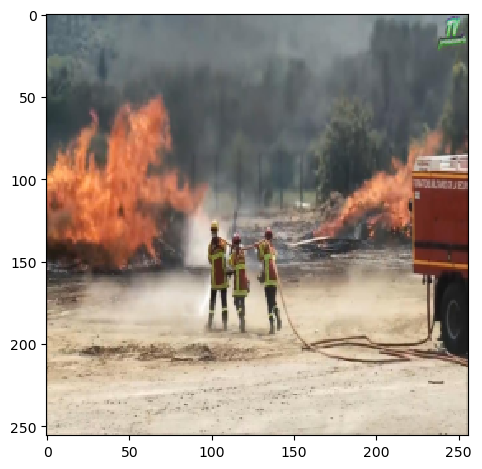

In [7]:
image_test = random.randint(0, TEST_LENGTH)

## Show actual vs masked image
img = X_test[image_test]
imshow(img)

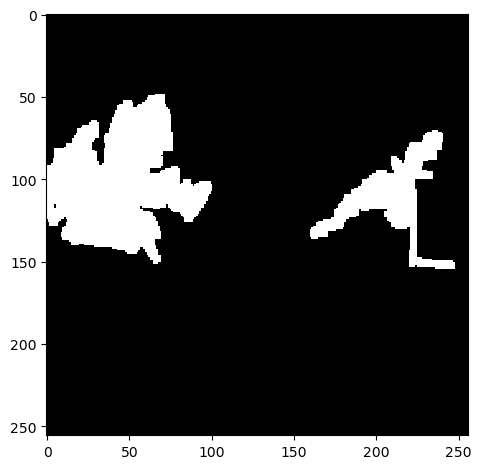

In [8]:
img = np.squeeze(Y_test[image_test])
imshow(img)

In [9]:
X_train, Y_train = resize_all(TRAIN_PATH, TRAIN_LENGTH, X_train, Y_train)

Processing images: 100%|██████████████████████| 500/500 [01:41<00:00,  4.93it/s]


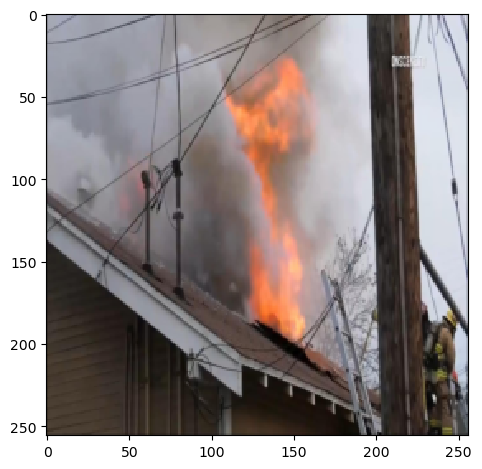

In [10]:
image_train = random.randint(0, TRAIN_LENGTH)

## Show actual vs masked image
img = X_train[image_train]
imshow(img)

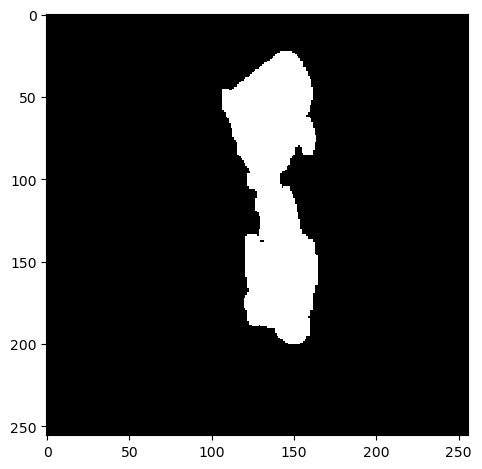

In [11]:
img = np.squeeze(Y_train[image_train])
imshow(img)

## U-Net Set Up

In [12]:
def custom_lambda(x):
    return x / 255


In [13]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(custom_lambda)(inputs)

#contraction
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


In [14]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("fire_segmentation.keras", verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs/'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

]

In [16]:
result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)


Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.7966 - loss: 0.5727 - val_accuracy: 0.9104 - val_loss: 0.2796 - learning_rate: 0.0010
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.9439 - loss: 0.1671 - val_accuracy: 0.9577 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.9639 - loss: 0.1046 - val_accuracy: 0.9637 - val_loss: 0.1280 - learning_rate: 0.0010
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step - accuracy: 0.9629 - loss: 0.1064 - val_accuracy: 0.9534 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.9569 - loss: 0.1128 - val_accuracy: 0.9664 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.9658 - loss: 0.0915 - val_accuracy: 0.9638 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 186s 6s/step - accuracy: 0.9673 - loss: 0.0898 - val_acc

## Evaluation

In [17]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [18]:
print(len(preds_test))

100


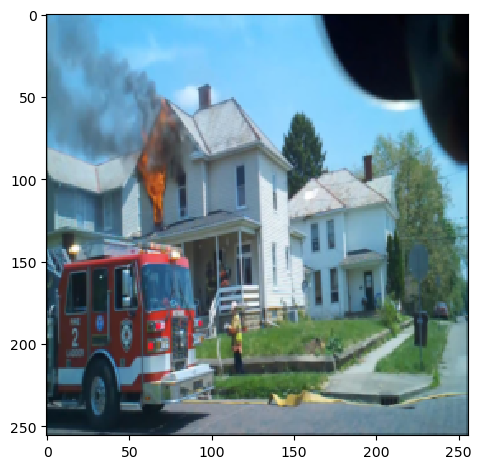

In [19]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])

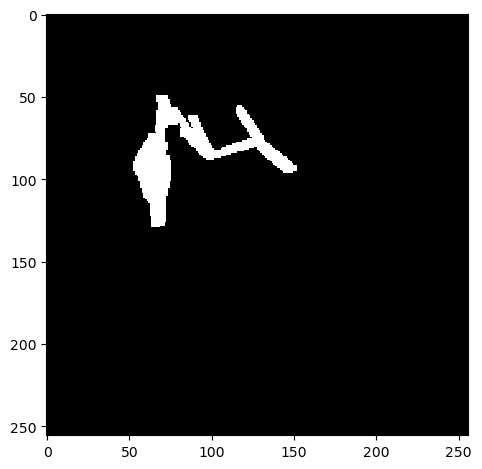

In [20]:
imshow(np.squeeze(Y_train[ix]))

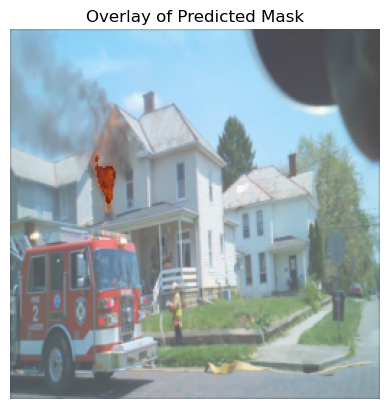

In [21]:
# imshow(np.squeeze(preds_train_t[ix]))
original_img = X_train[ix]
predicted_mask = preds_train_t[ix]

if predicted_mask.shape[-1] == 1:
    predicted_mask = np.squeeze(predicted_mask, axis=-1)

# Display the original image
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Overlay the mask on top of the image with a transparency
plt.imshow(predicted_mask, alpha=0.3, cmap='Reds')
plt.title("Overlay of Predicted Mask")
plt.axis('off')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


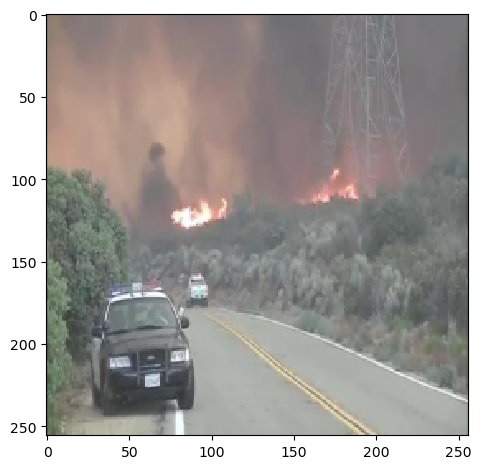

In [22]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])

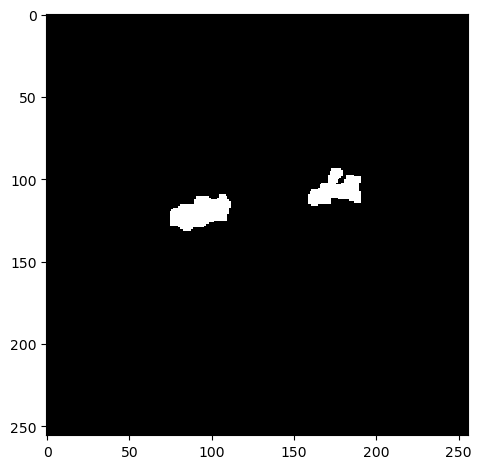

In [23]:
imshow(np.squeeze(Y_test[ix]))

In [24]:
# imshow(np.squeeze(preds_test_t[ix]))


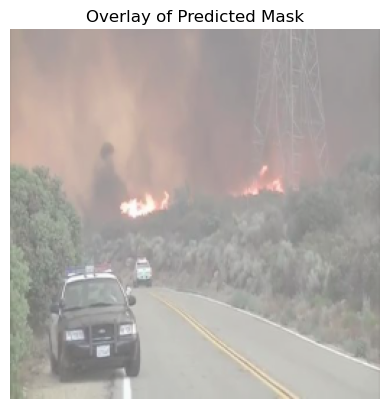

In [25]:
original_img = X_test[ix]
predicted_mask = preds_test_t[ix]

if predicted_mask.shape[-1] == 1:
    predicted_mask = np.squeeze(predicted_mask, axis=-1)

# Display the original image
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Overlay the mask on top of the image with a transparency
plt.imshow(predicted_mask, alpha=0.3, cmap='Reds')
plt.title("Overlay of Predicted Mask")
plt.axis('off')
plt.show()

## Categorisation

0.0 4


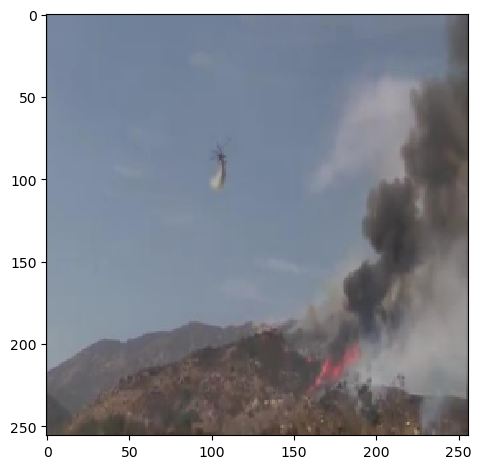

In [26]:
idx = random.randint(0, len(Y_test))
mask = np.array(preds_test_t[idx])

true_count = np.count_nonzero(mask)

ratio = true_count/(mask.size)

if ratio == 0:
    category = 4
elif ratio < 0.01:
    category = 3
elif ratio < 0.05:
    category = 2
else:
    category = 1

print(ratio, category)
imshow(X_test[idx])


In [29]:
model.save("fire_segmentation.keras", save_format='tf')

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [3]:
model_path = "fire_segmentation.keras"

def custom_lambda(x):
    return x / 255

custom_objects = {'custom_lambda': custom_lambda}

model = load_model("fire_segmentation.keras", custom_objects=custom_objects)


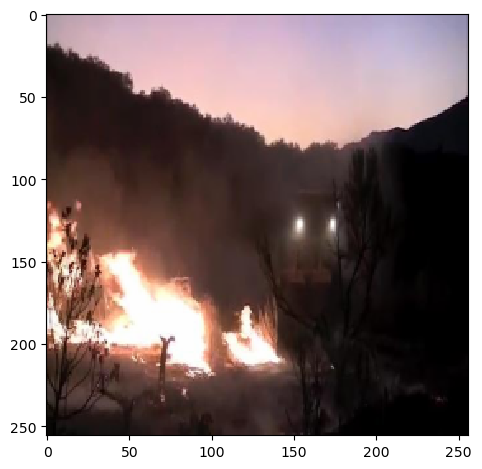

In [8]:
img = "./dataset/test/images/img(9).jpg"

img = imread(img)[:,:,:IMG_CHANNELS]
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
img = img.astype(np.uint8) 

imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


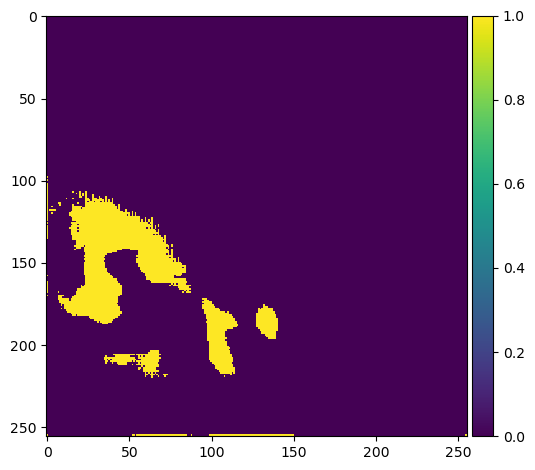

In [33]:
img_array = np.array(img) / 255.0

img_array = np.expand_dims(img, axis=0)
img_array.shape

preds_test = model.predict(img_array, verbose=1)

preds_test_t = (preds_test > 0.1).astype(np.uint8)

predicted_mask = preds_test_t[0]

if predicted_mask.shape[-1] == 1:
    predicted_mask = np.squeeze(predicted_mask, axis=-1)
    
imshow(predicted_mask)

In [19]:
# imshow(preds_test)

In [17]:
X_test = np.zeros((len(os.listdir(HOME + '/dataset/test/images')), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_test.shape

(100, 256, 256, 3)

In [18]:
X_test[0].shape

(256, 256, 3)